In [27]:
import matplotlib.pyplot as plt 
import json
from datasets import load_dataset, Dataset
import textstat
import numpy as np
import re
import pandas as pd
import textwrap

In [2]:
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""

def extract_hash_answer(text: str) -> str | None:
    return text.split("####")[-1].strip() if "####" in text else None

def get_gsm8k_questions(split="train") -> Dataset:
    data = load_dataset('openai/gsm8k', 'main')[split]
    data = data.map(lambda x: {
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']}
        ],
        'answer': extract_hash_answer(x['answer'])
    })
    return data

In [3]:
dataset = get_gsm8k_questions(split = "test")

In [ ]:
with open('all_outputs.json') as f:
    all_outputs = json.load(f)
len(all_outputs)

In [104]:
with open('tmp_outputs.json') as f:
    all_outputs[0] = json.load(f)

In [111]:
def get_answer(text: str) -> str:
    return text.split("<answer>")[1].split("</answer>")[0].strip()

def get_answer_rate(responses):
    correct, wrong = 0, 0
    for i, o in enumerate(responses):
        try: 
            ans = int(get_answer(o))
            if ans == int(dataset[i]['answer']):
                correct += 1
            else:
                wrong += 1
        except:
            pass
    return correct / (wrong + correct)

def get_total_average_flesch_kincaid(responses) -> float:
    scores = [textstat.flesch_kincaid_grade(r) for r in responses]
    return sum(scores) / len(scores)

def flesch_kincaid_reward_func(responses) -> float:
    scores = [textstat.flesch_kincaid_grade(r.split('<reasoning>')[-1].split('</reasoning>')[0]) for r in responses]
    return np.mean(scores)

def get_average_length(responses) -> list[float]:
    return sum([len(r) for r in responses]) / len(responses)

def soft_format_reward_func(responses) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    matches = [re.match(pattern, r, flags=re.DOTALL) for r in responses]
    return sum([1 if match else 0 for match in matches])

def has_reasoning(responses) -> list[float]:
    return sum([1 if ("<reasoning>" in r and '</reasoning>' in r) else 0 for r in responses])

def has_answer(responses) -> list[float]:
    return sum([1 if ("<answer>" in r and "</answer>" in r) else 0 for r in responses])

In [112]:
metrics = []
for outputs in all_outputs:
    metrics.append({
        "correct answer\n(when <answer> present)": get_answer_rate(outputs),
        "average_flesch_kincaid": get_total_average_flesch_kincaid(outputs),
        "reasoning flesch kincaid": flesch_kincaid_reward_func(outputs),
        "average_length": get_average_length(outputs),
        "soft_format_reward": soft_format_reward_func(outputs),
        "has reasoning tokens": has_reasoning(outputs),
        "has answer tokens": has_answer(outputs),
    })

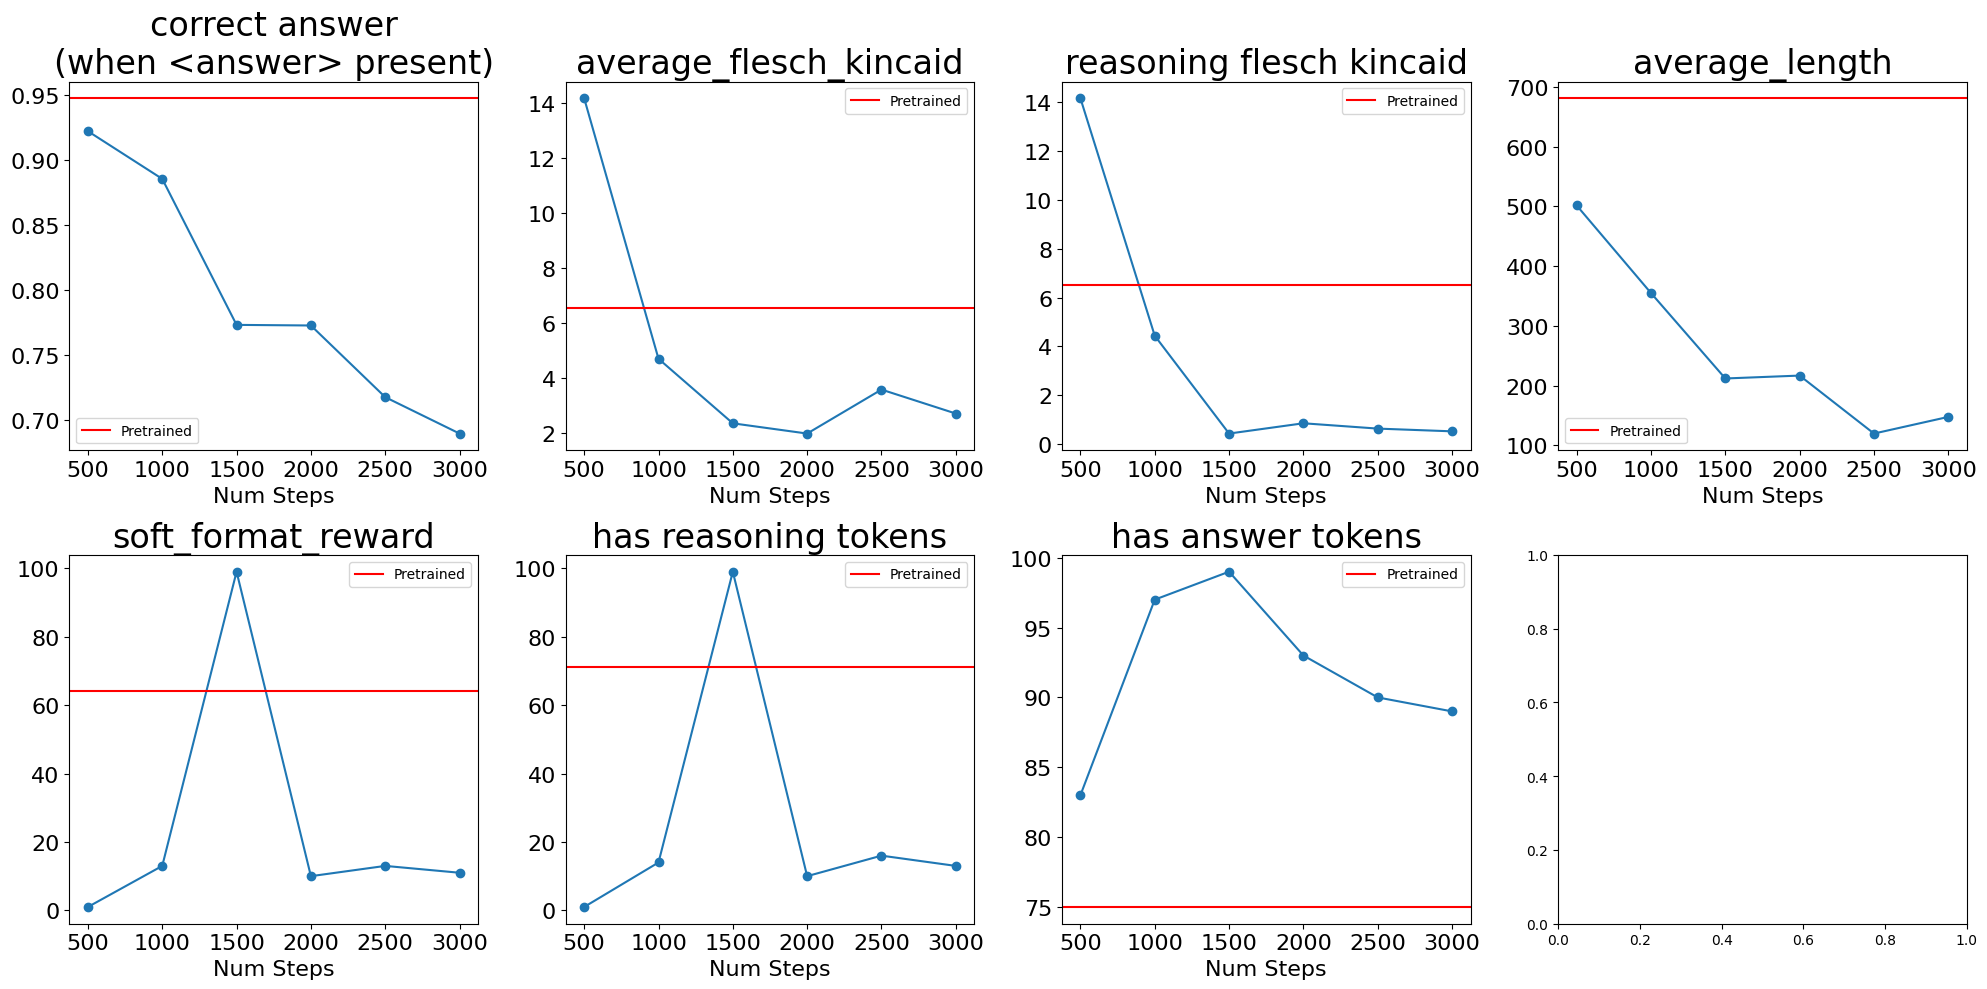

In [113]:
checkpoints = list(range(500, 3001, 500))
fig, axarr = plt.subplots(2,4, figsize=(20,10))
axarr = axarr.flatten()
cats = metrics[0].keys()
for ax, cat in zip(axarr, cats):
    y = [metrics[i][cat] for i in range(1, len(all_outputs))]
    ax.plot(checkpoints, y, marker='o')
    ax.axhline(metrics[0][cat], color='r', label='Pretrained')
    ax.legend()
    ax.set_title(cat, fontsize=24)
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Num Steps', fontsize=16)
plt.tight_layout()


In [ ]:
np.random.seed(1)
i_ = np.random.randint(len(all_outputs[0]), size=3)
response_dict = {}
answer_dict = {}
llm_names = ['pretrained'] + [str(s) for s in checkpoints]
for i in i_:
    i = int(i)
    question = dataset[i]['question']
    answer = dataset[i]['answer']
    response_dict[question] = [
        all_outputs[j][i] for j in range(len(all_outputs))
    ]
    answer_dict[question] = answer

for j, (k,vs) in enumerate(response_dict.items()):
    if j != 2:
        continue
    print('QUESTION:')
    wrapped_text = textwrap.fill(k, width=150)
    print(wrapped_text)
    print(f'ANSWER = {answer_dict[k]}')
    print('-------------')
    for i,v in enumerate(vs):
        wrapped_text = textwrap.fill(v, width=150)
        print(f'RESPONSE from {llm_names[i]}')
        print(wrapped_text)
        print('---------')
    break


In [102]:
print(question)

Tommy is fundraising for his charity by selling brownies for $3 a slice and cheesecakes for $4 a slice. If Tommy sells 43 brownies and 23 slices of cheesecake, how much money does Tommy raise?
